# Exercise Chapter 8 
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import warnings
import os
os.environ['OUTDATED_IGNORE'] = '1'
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import mistat
import networkx as nx
from pgmpy.estimators import HillClimbSearch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exercise 1

In [3]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation

dissolution = mistat.load_data('DISSOLUTION.csv')

# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'])

In [4]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()

fd_registered = {}
for order in (1, 2, 3):
    fd.interpolation = SplineInterpolation(interpolation_order=order)
    fd_registered[order] = shift_registration.fit_transform(fd)

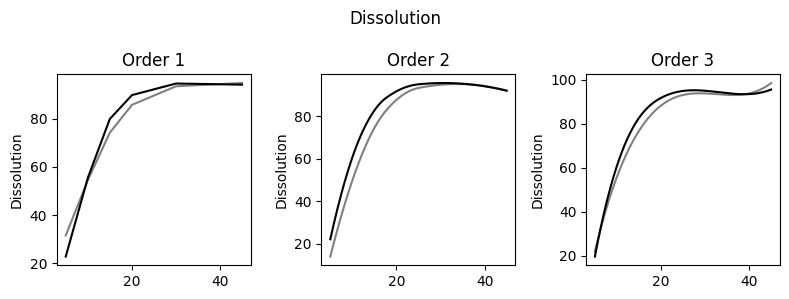

In [5]:
from skfda.exploratory import stats

group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, order in zip(axes, (1, 2, 3)):
    mean_ref = stats.mean(fd_registered[order][labels=='Reference'])
    mean_test = stats.mean(fd_registered[order][labels=='Test'])
    means = mean_ref.concatenate(mean_test)
    means.plot(axes=[ax], group=['Reference', 'Test'], group_colors=group_colors)
    ax.set_title(f'Order {order}')
plt.tight_layout()

# Exercise 2

In [6]:
import skfda
from skfda import FDataGrid

pinchraw = skfda.datasets.fetch_cran('pinchraw', 'fda')['pinchraw']
pinchtime = skfda.datasets.fetch_cran('pinch', 'fda')['pinchtime']

fd = FDataGrid(pinchraw.transpose(), pinchtime)

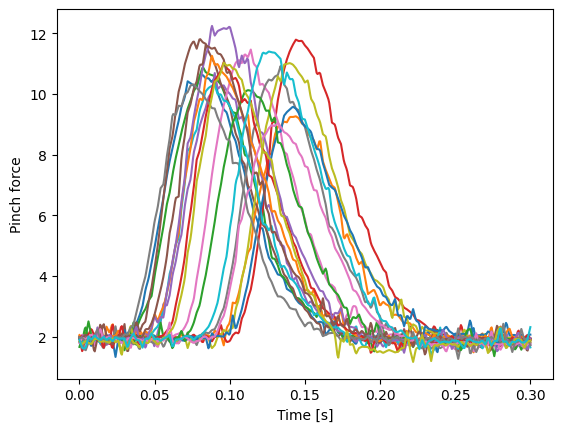

In [7]:
fig = fd.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

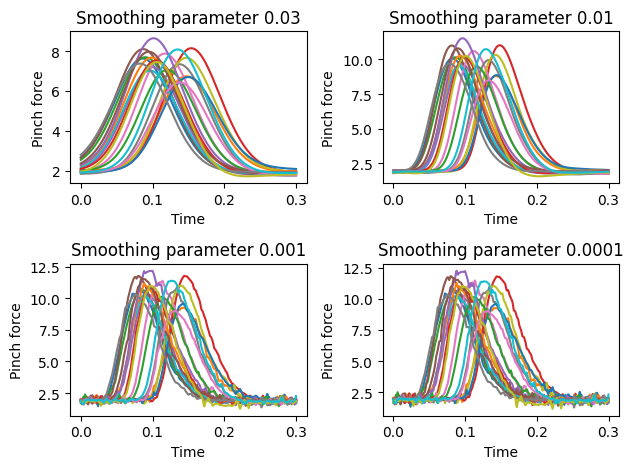

In [8]:
import itertools
from skfda.preprocessing.smoothing.kernel_smoothers import NadarayaWatsonSmoother

def plotSmoothData(fd, smoothing_parameter, ax):
    smoother = NadarayaWatsonSmoother(smoothing_parameter=smoothing_parameter)
    fd_smooth = smoother.fit_transform(fd)
    _ = fd_smooth.plot(axes=[ax])
    ax.set_title(f'Smoothing parameter {smoothing_parameter}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Pinch force')

fig, axes = plt.subplots(ncols=2, nrows=2)
axes = list(itertools.chain(*axes))  # flatten list of lists
for i, sp in enumerate([0.03, 0.01, 0.001, 0.0001]):
    plotSmoothData(fd, sp, axes[i])
plt.tight_layout()

In [9]:
smoother = NadarayaWatsonSmoother(smoothing_parameter=0.005)
fd_smooth = smoother.fit_transform(fd)

In [10]:
max_idx = fd_smooth.data_matrix.argmax(axis=1)
landmarks = [pinchtime[idx] for idx in max_idx]

In [11]:
from skfda.preprocessing.registration import landmark_shift
fd_landmark = landmark_shift(fd_smooth, landmarks)

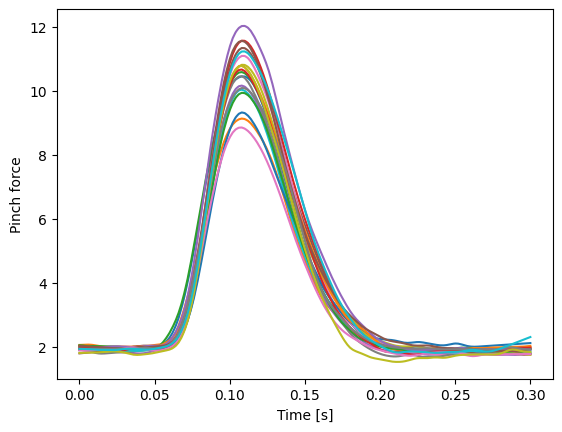

In [12]:
fig = fd_landmark.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

# Exercise 3

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [14]:
import skfda

moisturespectrum = skfda.datasets.fetch_cran('Moisturespectrum', 'fds')
moisturevalues = skfda.datasets.fetch_cran('Moisturevalues', 'fds')

frequencies = moisturespectrum['Moisturespectrum']['x']
spectra = moisturespectrum['Moisturespectrum']['y']
moisture = moisturevalues['Moisturevalues']

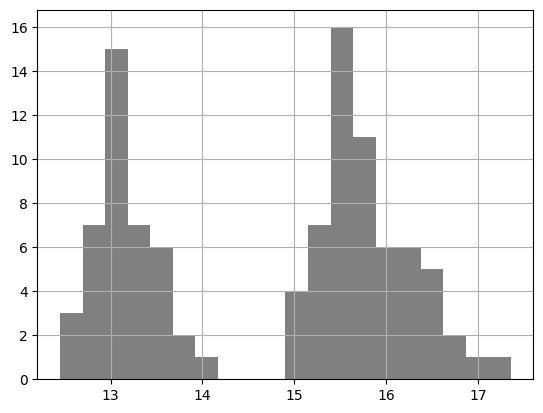

In [15]:
_ = pd.Series(moisture).hist(bins=20, color='grey', label='Moisture content')

In [16]:
moisture_class = ['high' if m > 14.5 else 'low' for m in moisture]

In [17]:
intensities = spectra.transpose()
fd = skfda.FDataGrid(intensities, frequencies)

# divide each sample spectrum by it's mean intensities
intensities_normalized = (intensities - intensities.mean(dim='dim_0')) / intensities.std(dim='dim_0')
fd_normalized = skfda.FDataGrid(intensities_normalized, frequencies)

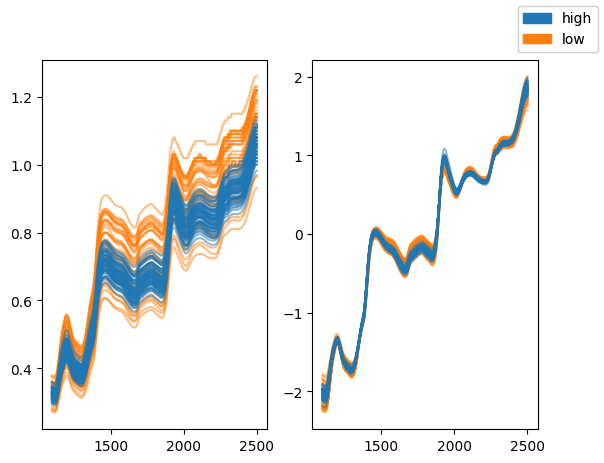

In [18]:
fig, axes = plt.subplots(ncols=2)
_ = fd.plot(axes=axes[0], alpha=0.5,
            # color lines by moisture class
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})
_ = fd_normalized.plot(axes=axes[1], alpha=0.5,
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})

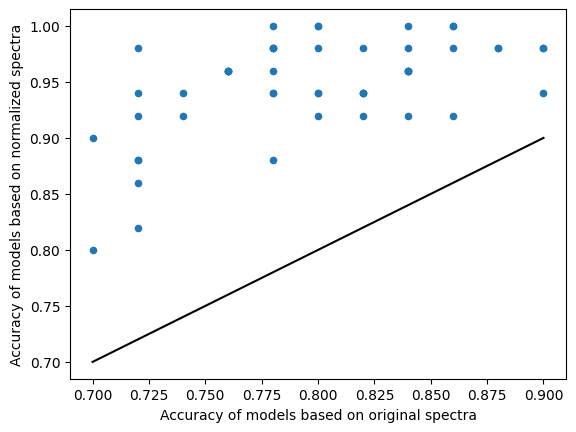

original      0.7976
normalized    0.9468
dtype: float64

In [19]:
from skfda.ml.classification import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

accuracies = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture_class, random_state=rs, test_size=0.5)
    knn_original = KNeighborsClassifier()
    knn_original.fit(X_train, y_train)
    acc_original = accuracy_score(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture_class, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsClassifier()
    knn_normalized.fit(X_train, y_train)
    acc_normalized = accuracy_score(y_test, knn_normalized.predict(X_test))
    accuracies.append({
        'original': acc_original,
        'normalized': acc_normalized,
    })
accuracies = pd.DataFrame(accuracies)
ax  = accuracies.plot.scatter(x='original', y='normalized')
_ = ax.plot([0.7, 0.9], [0.7, 0.9], color='black')
ax.set_xlabel('Accuracy of models based on original spectra')
ax.set_ylabel('Accuracy of models based on normalized spectra')
plt.show()

# mean of accuracies
mean_accuracy = accuracies.mean()
mean_accuracy

# Exercise 4

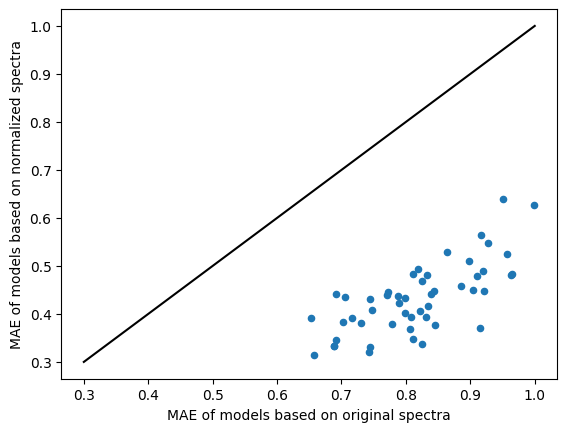

original      0.817016
normalized    0.433026
dtype: float64

In [20]:
from skfda.ml.regression import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

mae = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture, random_state=rs, test_size=0.5)
    knn_original = KNeighborsRegressor()
    knn_original.fit(X_train, y_train)
    mae_original = mean_absolute_error(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsRegressor()
    knn_normalized.fit(X_train, y_train)
    mae_normalized = mean_absolute_error(y_test, knn_normalized.predict(X_test))
    mae.append({
        'original': mae_original,
        'normalized': mae_normalized,
    })
mae = pd.DataFrame(mae)
ax  = mae.plot.scatter(x='original', y='normalized')
ax.plot([0.3, 1.0], [0.3, 1.0], color='black')
ax.set_xlabel('MAE of models based on original spectra')
ax.set_ylabel('MAE of models based on normalized spectra')
plt.show()

# mean of MAE
mean_mae = mae.mean()
mean_mae

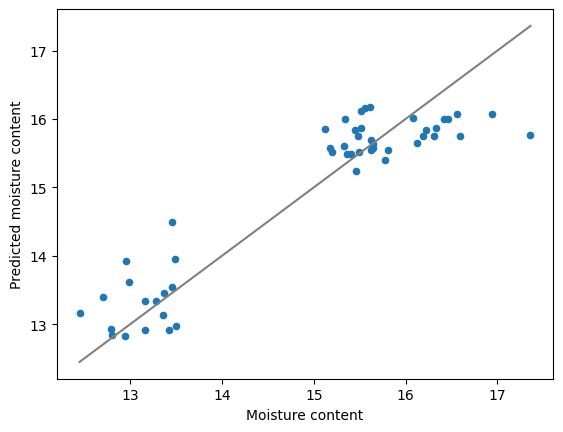

In [21]:
y_pred = knn_normalized.predict(X_test)
predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
minmax = [min(*y_test, *y_pred), max(*y_test, *y_pred)]

ax = predictions.plot.scatter(x='actual', y='predicted')
ax.set_xlabel('Moisture content')
ax.set_ylabel('Predicted moisture content')
ax.plot(minmax, minmax, color='grey')
plt.show()

# Exercise 5

In [22]:
from skfda.preprocessing.dim_reduction.projection import FPCA

fpca_original = FPCA(n_components=2)
_ = fpca_original.fit(fd)

fpca_normalized = FPCA(n_components=2)
_ = fpca_normalized.fit(fd_normalized)

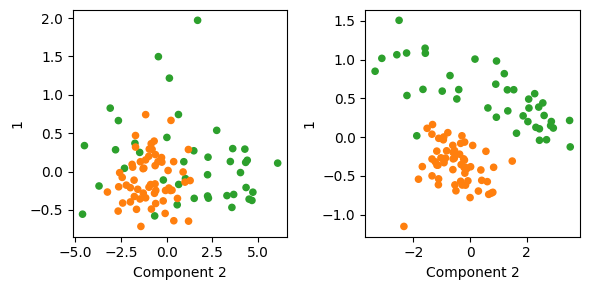

In [23]:
def plotFPCA(fpca, fd, ax):
  fpca_df = pd.DataFrame(fpca.transform(fd))
  fpca_df.plot.scatter(x=0, y=1,
      c=['C1' if mc == 'high' else 'C2' for mc in moisture_class], ax=ax)
  ax.set_xlabel('Component 1')
  ax.set_xlabel('Component 2')

fig, axes = plt.subplots(ncols=2, figsize=[6, 3])
plotFPCA(fpca_original, fd, axes[0])
plotFPCA(fpca_normalized, fd_normalized, axes[1])
plt.tight_layout()

# Exercise 6

In [24]:
from mistat.nlp import globalWarmingBlogs
blogs = globalWarmingBlogs()

In [25]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph: # ignore empty paragraphs
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (123, 1025)
total number of terms 2946


In [27]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]:14s}  {termCounts[n]:3d}')

global           63
climate          59
warming          57
change           55
ice              35
sea              34
earth            33
ocean            29
temperatures     28
heat             25


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(5)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [30]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [31]:
df

Topic 1  Loading 1    Topic 2  Loading 2     Topic 3  Loading 3  \
0       change   0.238430        ice   0.390981         sea   0.252240   
1      climate   0.237706        sea   0.344788       earth   0.232203   
2       global   0.233771     sheets   0.272952      energy   0.202881   
3          sea   0.219121  shrinking   0.194367       light   0.200711   
4      warming   0.210336      level   0.167861         ice   0.187888   
5          ice   0.198422     arctic   0.151159       gases   0.182041   
6  temperature   0.175026      ocean   0.125875    infrared   0.162602   
7        ocean   0.164878  declining   0.102133  greenhouse   0.147605   
8        earth   0.156233     levels   0.080160       level   0.145114   
9      extreme   0.149370   glaciers   0.072554      arctic   0.125934   

         Topic 4  Loading 4       Topic 5  Loading 5  
0        extreme   0.517916          snow   0.389354  
1         events   0.286985         cover   0.230862  
2           heat   0.241076           sea   0.178501  
3  precipitation   0.202858         level   0.138065  
4          earth   0.143361    hurricanes   0.122872  
5          light   0.139268  temperatures   0.120875  
6         energy   0.130947       climate   0.112727  
7          gases   0.128985     decreased   0.105559  
8       infrared   0.113065          rise   0.102034  
9     greenhouse   0.111063      increase   0.101608

In [32]:
svd = TruncatedSVD(10)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [33]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [34]:
df

Topic 1  Loading 1    Topic 2  Loading 2     Topic 3  Loading 3  \
0       change   0.238515        ice   0.391064         sea   0.248355   
1      climate   0.237891        sea   0.345134       earth   0.235125   
2       global   0.234030     sheets   0.271863      energy   0.214499   
3          sea   0.219088  shrinking   0.193468       light   0.210516   
4      warming   0.210595      level   0.168157       gases   0.189875   
5          ice   0.198541     arctic   0.151694         ice   0.180430   
6  temperature   0.175104      ocean   0.127539    infrared   0.171499   
7        ocean   0.164639  declining   0.102248  greenhouse   0.158485   
8        earth   0.156244     levels   0.079709       level   0.151823   
9      extreme   0.149387   glaciers   0.073559  atmosphere   0.122354   

         Topic 4  Loading 4       Topic 5  Loading 5      Topic 6  Loading 6  \
0        extreme   0.536233          snow   0.389130          sea   0.368579   
1         events   0.306403         cover   0.235360        level   0.354574   
2           heat   0.236859           sea   0.179517         rise   0.163652   
3  precipitation   0.202743         level   0.122728      extreme   0.140977   
4          earth   0.126673    hurricanes   0.120653   hurricanes   0.112978   
5          light   0.122152  temperatures   0.118627       events   0.111753   
6          gases   0.114393     decreased   0.116094       global   0.105706   
7         energy   0.112936       climate   0.113792      impacts   0.100276   
8     greenhouse   0.103288   temperature   0.100491  temperature   0.096294   
9       infrared   0.099793      increase   0.099207      coastal   0.077879   

         Topic 7  Loading 7        Topic 8  Loading 8   Topic 9  Loading 9  \
0           snow   0.308323          ocean   0.371329  glaciers   0.365199   
1          ocean   0.304149     hurricanes   0.193667   retreat   0.249439   
2          cover   0.217341  acidification   0.180229     water   0.233219   
3  acidification   0.187721       glaciers   0.175783   glacial   0.219038   
4        extreme   0.148922          water   0.137675    months   0.151641   
5         carbon   0.134438         waters   0.115512    summer   0.132392   
6      pollution   0.131428   temperatures   0.102923    plants   0.127433   
7      decreased   0.113491        glacial   0.085368     going   0.114716   
8         waters   0.108955     retreating   0.085084   animals   0.110211   
9          point   0.107372         marine   0.079734    stream   0.107108   

                Topic 10  Loading 10  
0  howglobalwarmingworks    0.184136  
1                    org    0.184136  
2             hurricanes    0.173058  
3                   know    0.164476  
4                  video    0.155485  
5                   idea    0.136879  
6                  folks    0.136879  
7                     ok    0.136879  
8               glaciers    0.122494  
9                 really    0.120120

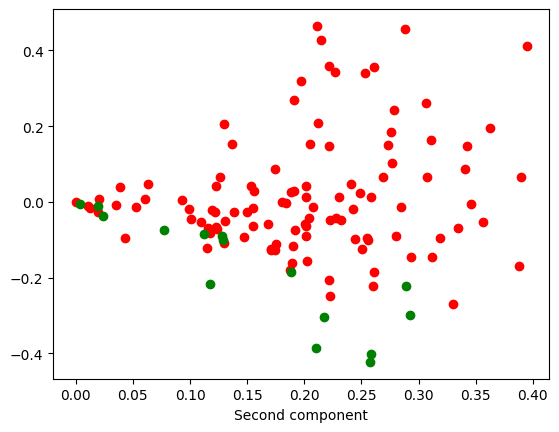

In [35]:
fig, ax = plt.subplots()
blog1 = [label == 'blog-1' for label in labels]
blog2 = [label == 'blog-2' for label in labels]
ax.plot(lsa_tfidf[blog1, 0], lsa_tfidf[blog1, 1], 'ro')
ax.plot(lsa_tfidf[blog2, 0], lsa_tfidf[blog2, 1], 'go')
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 7

In [36]:
from mistat.nlp import covid19Blogs
blogs = covid19Blogs()

In [37]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph:
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

def preprocessor(text):
  text = text.lower()
  text = re.sub(r'\d[\d,]*', '', text)
  text = '\n'.join(line for line in text.split('\n')
                   if not line.startswith('ntsb'))
  return text

vectorizer = CountVectorizer(preprocessor=preprocessor, stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

In [38]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [39]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)

In [40]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [41]:
df

Topic 1  Loading 1      Topic 2  Loading 2   Topic 3  Loading 3  \
0    labour   0.286590       labour   0.275916  economic   0.236958   
1     covid   0.217621        south   0.271569   percent   0.228522   
2    impact   0.193955        north   0.215211     covid   0.194973   
3    market   0.188408  differences   0.192772       gdp   0.171747   
4     south   0.181831     americas   0.169769    impact   0.147596   
5   america   0.159907      channel   0.152380       imf   0.132329   
6  pandemic   0.151557       agenda   0.141276    social   0.123975   
7   channel   0.150944        covid   0.131200       pre   0.115692   
8  economic   0.140793         post   0.108231    growth   0.102543   
9     north   0.137111      welfare   0.093217     world   0.098955   

         Topic 4  Loading 4   Topic 5  Loading 5       Topic 6  Loading 6  \
0      financial   0.206088   america   0.219928      economic   0.286936   
1       capacity   0.200680     reset   0.212921       channel   0.221359   
2          firms   0.182157     latin   0.195212        social   0.167269   
3      household   0.167829     covid   0.189399        market   0.163456   
4  international   0.160789     needs   0.165267      recovery   0.126912   
5        largely   0.134021  economic   0.132128        labour   0.101849   
6        depends   0.134021    social   0.131915  preservation   0.094638   
7        markets   0.133132    region   0.126414        impact   0.091734   
8         access   0.131211    crisis   0.095597   governments   0.080918   
9          state   0.127353     labor   0.094346   preliminary   0.078480   

        Topic 7  Loading 7      Topic 8  Loading 8        Topic 9  Loading 9  \
0   occupations   0.225293        south   0.158796           self   0.191872   
1      economic   0.215180        north   0.154135       employed   0.173857   
2         covid   0.205642       crisis   0.148379     unbearable   0.168488   
3  consequences   0.185765      poverty   0.140283      lightness   0.168488   
4    asymmetric   0.183199       deepen   0.137036  international   0.142473   
5    transition   0.139206  differences   0.134161      financial   0.128647   
6    occupation   0.128995   inequality   0.128605       informal   0.126235   
7        social   0.126709        labor   0.127571        poverty   0.102811   
8   differences   0.126419       remote   0.114267     inequality   0.094810   
9         north   0.118878      working   0.113982         social   0.087827   

      Topic 10  Loading 10  
0        needs    0.140462  
1  differences    0.138026  
2        north    0.137778  
3     americas    0.136238  
4         need    0.125043  
5        south    0.119283  
6        reset    0.108039  
7        covid    0.108038  
8  governments    0.105558  
9         cash    0.096459

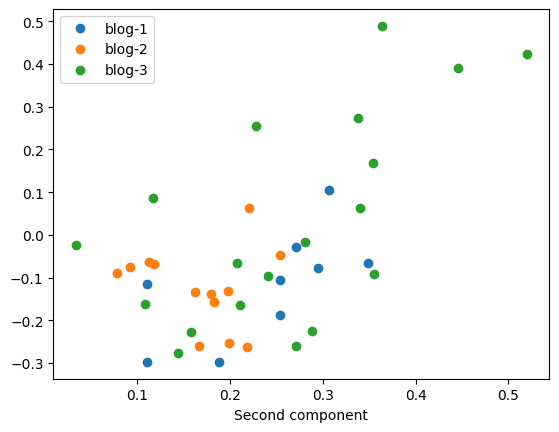

In [42]:
fig, ax = plt.subplots()
for blog in blogs:
    match = [label == blog for label in labels]
    ax.plot(lsa_tfidf[match, 0], lsa_tfidf[match, 1], 'o', label=blog)
ax.legend()
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 8

In [43]:
data = mistat.load_data('LAPTOP_REVIEWS')
data['Review'] = data['Review title'] + ' ' + data['Review content']
reviews = data.dropna(subset=['User rating', 'Review title', 'Review content'])

In [44]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(reviews['Review'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (7433, 12823)
total number of terms 251566


In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(20)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(7433, 20)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

outcome = ['positive' if rating == 5 else 'negative'
           for rating in reviews['User rating']]

# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, outcome,
                                                test_size=0.4, random_state=1)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
accuracy = accuracy_score(ytest, logit_reg.predict(Xtest))
print(accuracy)
confusion_matrix(ytest, logit_reg.predict(Xtest))

0.7683254875588433


array([[ 861,  385],
       [ 304, 1424]])